In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Softmax, Multiply
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D

C:\Users\iuryc\miniconda3\envs\env_pdi\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\iuryc\miniconda3\envs\env_pdi\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\iuryc\miniconda3\envs\env_pdi\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\iuryc\miniconda3\envs\env_pdi\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os                                             # Operational System para manipulação de arquivos.
import cv2                                            # OpenCV para manipulação de imagens.
import random
from sklearn.metrics import confusion_matrix, classification_report    # Scikit-Learn para plotar a matriz de confusão e classification_report
import tensorflow as tf
from tensorflow.keras import layers                   # Módulo de camadas do Keras
from tensorflow.keras import callbacks                # Módulo de callbacks do Keras
from tensorflow.keras import optimizers               # Módulo de otimizadores do Keras
from tensorflow.keras.models import load_model        # Função para carregar um modelo salvo
from tensorflow.keras.models import Sequential        # Classe de modelos sequenciais para construir as redes neurais.
import seaborn as sns
import time

In [3]:
df = pd.read_csv('GroundTruth.csv', header=0 ) #importando o arquivo e especificando o cabeçalho

In [4]:
df=pd.read_csv('GroundTruth.csv')
print (df.head())
print (len(df))
print (df.columns)
labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
10015
Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')


In [5]:
df['image']=df['image'].apply(lambda x: x+ '.jpg')

In [6]:
labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_list=[]
for i in range (len(df)):
    row= list(df.iloc[i])
    del row[0]
    index=np.argmax(row)
    label=labels[index]
    label_list.append(label)
df['label']= label_list
df=df.drop(labels, axis=1)
print (df.head())

              image label
0  ISIC_0024306.jpg    NV
1  ISIC_0024307.jpg    NV
2  ISIC_0024308.jpg    NV
3  ISIC_0024309.jpg    NV
4  ISIC_0024310.jpg   MEL


In [7]:
train_split=.90
valid_split=.05
dummy_split=valid_split/(1-train_split)
train_df, dummy_df= train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
valid_df, test_df= train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)

print(' train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
print (train_df.head())
print (train_df['label'].value_counts())

 train_df length:  9013   test_df length:  501   valid_df length:  501
                 image label
8421  ISIC_0032727.jpg   BCC
3876  ISIC_0028182.jpg    NV
685   ISIC_0024991.jpg    NV
8409  ISIC_0032715.jpg  VASC
6201  ISIC_0030507.jpg   MEL
NV       6045
MEL       997
BKL       976
BCC       469
AKIEC     295
VASC      129
DF        102
Name: label, dtype: int64


In [8]:
batch_size= 16
datagen = tf.keras.preprocessing.image.ImageDataGenerator(

        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'

    )

In [9]:
sdir=r'images/'
height=224  # image height
width=224 # image width
channels=3  # number of coloor channels
batch_size= 40  # model batch size for training and evaluation
img_shape=(height, width, channels)
img_size=(height, width)

# code below determines test generator batch size and steps so that test_batch_size X test_steps = number of test samples
# ensures that for predictions you go through the test set exactly once
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

train_gen=datagen.flow_from_dataframe( train_df, sdir, x_col='image', y_col='label',target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=datagen.flow_from_dataframe( test_df, sdir, x_col='image', y_col='label', target_size=img_size,class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=datagen.flow_from_dataframe( valid_df, sdir, x_col='image', y_col='label',target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

classes=list(train_gen.class_indices.keys())

class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

test batch size:  3   test steps:  167
Found 9013 validated image filenames belonging to 7 classes.
Found 501 validated image filenames belonging to 7 classes.
Found 501 validated image filenames belonging to 7 classes.


In [10]:
model = tf.keras.models.load_model('EfficientNet+SA.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [42]:
predictions = model.predict(test_gen)

true_labels = test_gen.classes

predicted_labels = np.argmax(predictions, axis=1)

167/167 [==============================] - 25s 147ms/step


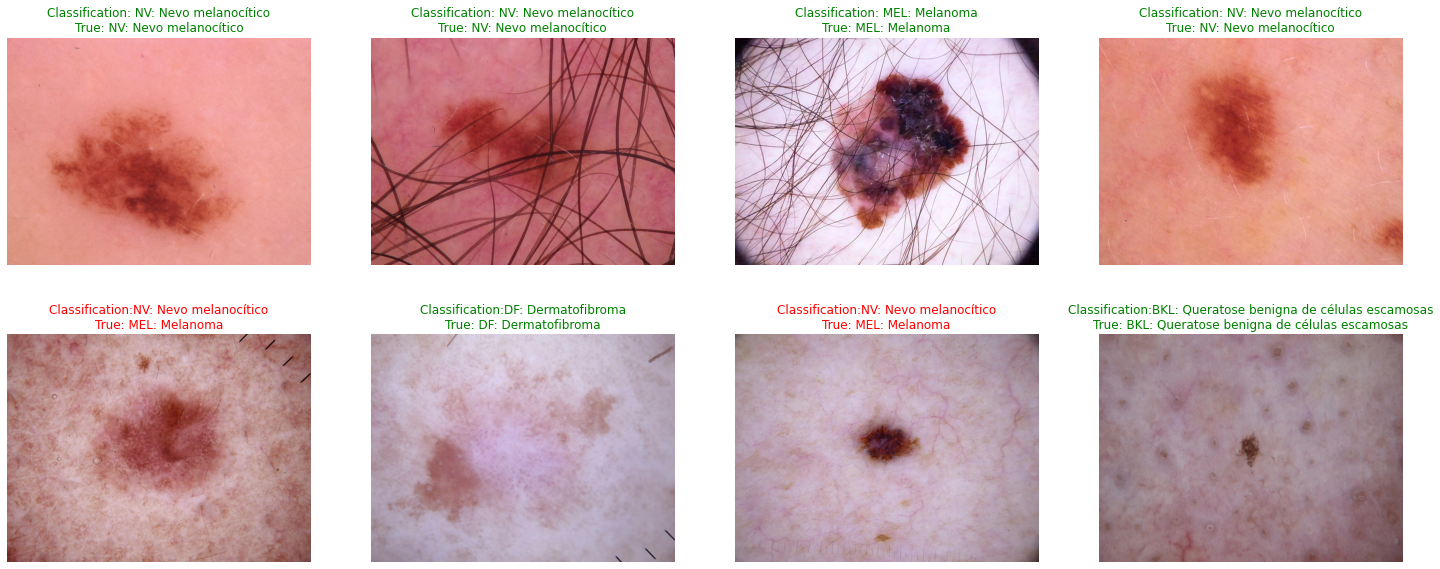

In [63]:
class_names = [
    'AKIEC: Queratose actínica e carcinoma intraepidérmico',
    'BCC: Carcinoma basocelular',
    'BKL: Queratose benigna de células escamosas',
    'DF: Dermatofibroma',
    'MEL: Melanoma',
    'NV: Nevo melanocítico',
    'VASC: Lesões vasculares'
]

# Gere subplots com títulos formatados conforme suas instruções
fig, axs = plt.subplots(2, 4, figsize=(25, 10))
for i in range(2):
    if i==0:
        for j in range (0,4):
            if true_labels[j] == predicted_labels[j]:
                title_color = 'green'
            else:
                title_color = 'red'

            image = plt.imread(test_gen.filepaths[j])  
            axs[i,j].imshow(image)
            axs[i,j].set_title(f'Classification: {class_names[predicted_labels[j]]}\nTrue: {class_names[true_labels[j]]}', color=title_color)
            axs[i,j].axis('off')
    else:
        for j in range (4,9):
            if true_labels[j] == predicted_labels[j]:
                title_color = 'green'
            else:
                title_color = 'red'

            image = plt.imread(test_gen.filepaths[j]) 
            axs[i,j-5].imshow(image) 
            axs[i,j-5].set_title(f'Classification:{class_names[predicted_labels[j]]}\nTrue: {class_names[true_labels[j]]}', color=title_color)
            axs[i,j-5].axis('off')

plt.savefig('subplots_classificacoes.jpg')
plt.show()

In [38]:
for i in range (2):
    if i == 0 :
        for j in range (0,5):
            print(j)
    else: 
        for j in range (5,10):
            print(j)

0
1
2
3
4
5
6
7
8
9
